# What Are Text Embeddings?

Text embeddings are numerical representations of text that capture its semantic meaning in a way that can be understood and processed by machine learning models. They transform words, phrases, sentences, or even entire documents into dense vectors of real numbers, typically in a high-dimensional space.

These vectors encode the context, relationships, and meaning of the text such that similar meanings result in vectors that are close together, while unrelated meanings are far apart. This makes embeddings a foundational component in many natural language processing (NLP) tasks.

- `Semantic Representation`: Embeddings capture not just the surface form of words, but their meaning in context.

- `Fixed-Length Vectors`: Regardless of the length of the input text, the resulting embedding is typically a fixed-size vector (e.g., 384, 768, or 1536 dimensions).

- `High-Dimensional Space`: Embeddings exist in a multi-dimensional vector space where spatial relationships reflect semantic similarity.



# What Is a Vector Database?

A Vector Database is a specialized type of database designed to store, index, and search high-dimensional vector representations, such as those generated by text embeddings, image embeddings, or other machine learning models. These databases are optimized for similarity search, enabling fast and accurate retrieval of items that are semantically or conceptually similar to a given query.

In the context of natural language processing (NLP), a vector database is commonly used to store text embeddings—dense vector representations of sentences, documents, or queries—allowing systems to perform semantic search, recommendation, and retrieval-augmented generation (RAG).

- `High-Dimensional Vector Storage`: Efficiently stores embeddings that may have hundreds or thousands of dimensions.

- `Approximate Nearest Neighbor (ANN) Search`: Uses optimized algorithms (e.g., HNSW, IVF, PQ) to retrieve vectors that are closest to a query vector based on a distance metric (e.g., cosine similarity, Euclidean distance).

- `Scalability`: Designed to handle millions to billions of vectors while maintaining low-latency search.

- `Metadata Association`: Allows vectors to be stored along with metadata (e.g., document IDs, tags) for contextual filtering or retrieval.


**How It Works**

1. `Input Conversion`: Text, image, or other data is converted into a fixed-size vector using a model like OpenAI’s embedding model or Sentence-BERT.

2. `Storage`: The resulting vector, along with optional metadata, is stored in the vector database.

3. `Querying`: A query is converted into a vector, and the database searches for the most similar vectors using distance-based similarity.

4. `Result Return`: The top-N most similar items (e.g., documents, products, answers) are returned.



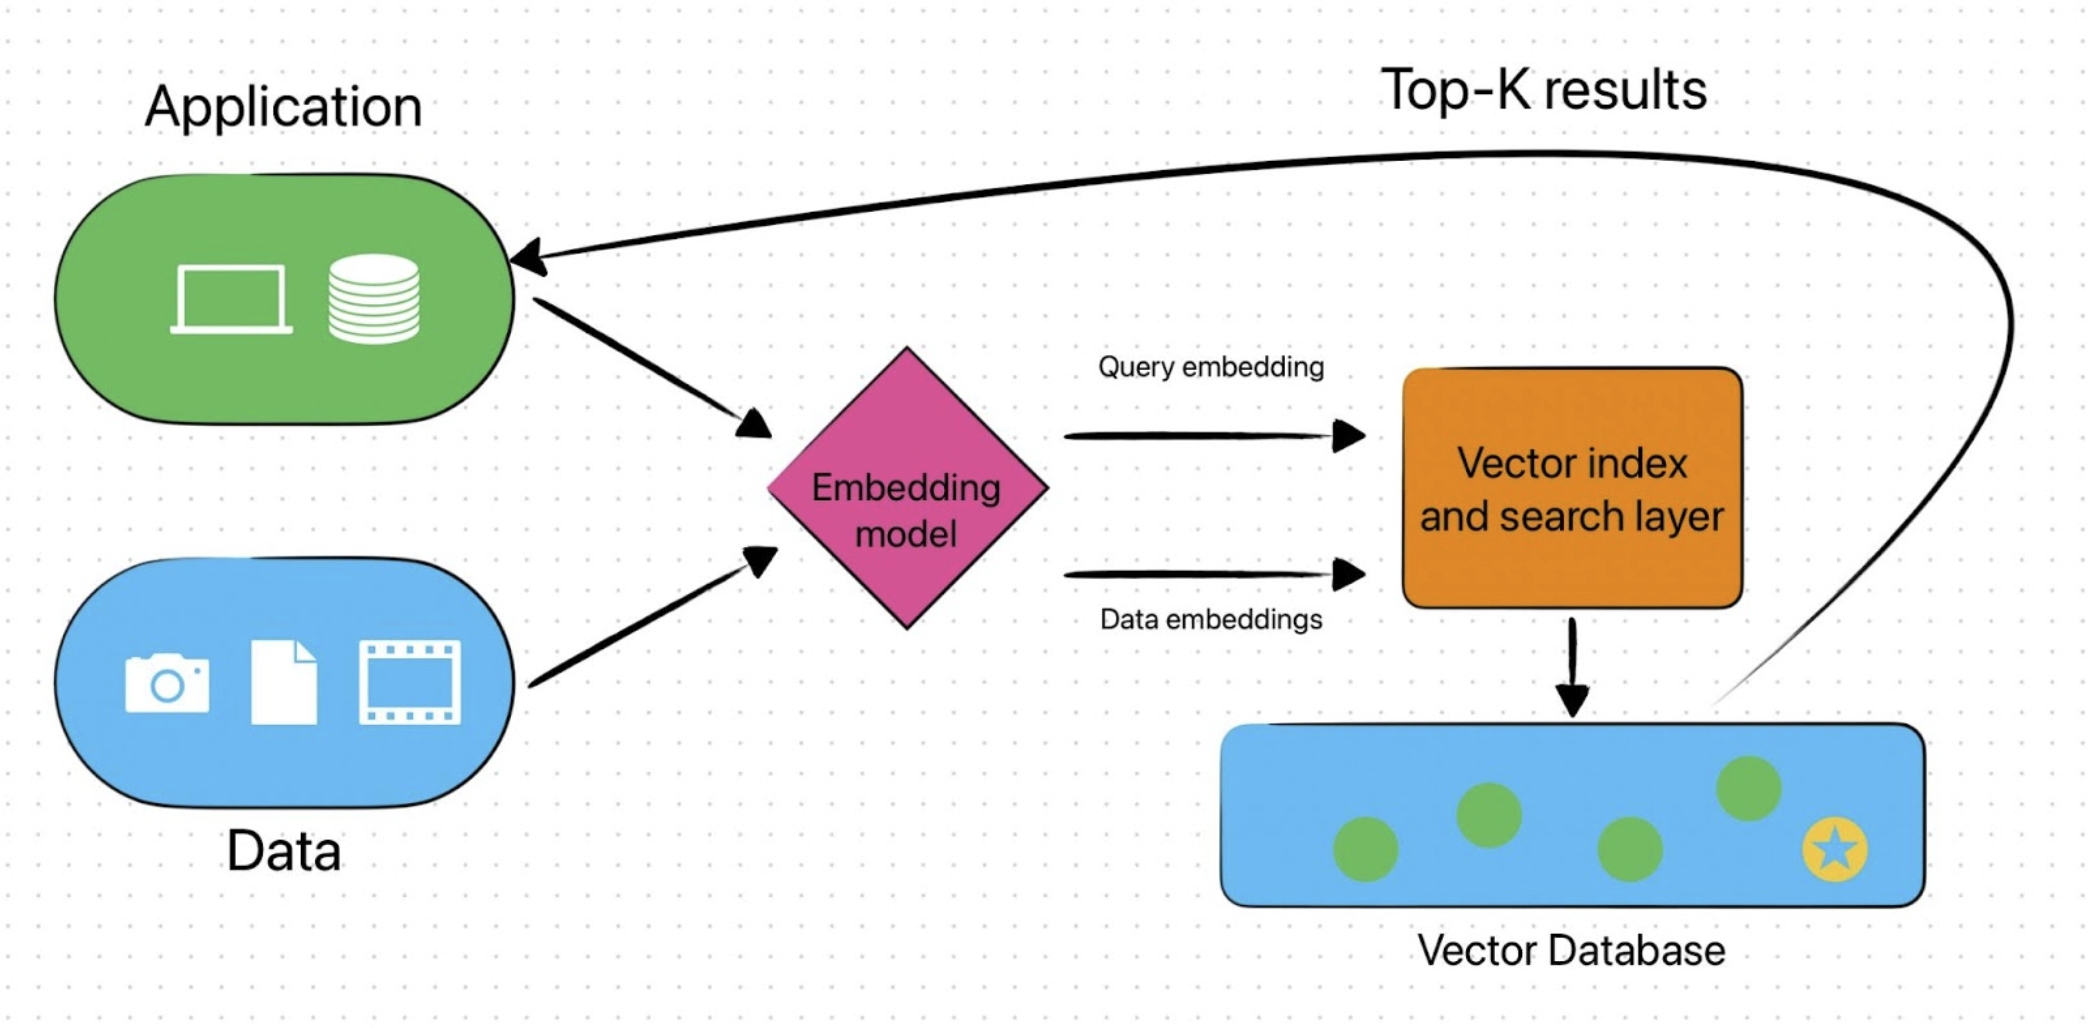

# Setting Up Work Environment

In [3]:
# Install required libraries
!pip install --upgrade google-generativeai                 # Install Google Generative AI (Gemini) SDK
!pip install -q -U google-genai                            # Another variant of Google Generative AI SDK
!pip install langchain-community                           # Community-supported LangChain tools
!pip install docarray                                      # Used for storing and searching documents in memory
!pip install -U langchain-google-genai                     # LangChain integration for Google Generative AI (Gemini)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [1]:
import os
from google import genai                              # Google GenAI main module
import google.generativeai as ggenai                  # Another way to access the GenAI functionality
from google.colab import userdata                     # For securely retrieving secrets in Colab

# LangChain integrations with Gemini
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# LangChain utilities
from langchain.indexes import VectorstoreIndexCreator  # Helps create vector index from loaders
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA                # LangChain's retrieval-based QA chain
from langchain.document_loaders import CSVLoader        # Loads documents from CSV
from IPython.display import display, Markdown           # For displaying markdown in Colab notebooks

In [2]:
# Get the Gemini API key stored securely in Colab
key = userdata.get('genai_api')

# Instantiate a GenAI client with the key
client = genai.Client(api_key=key)

# Configure the generative AI with the same key for further calls
ggenai.configure(api_key=key)

List the set of available models

In [3]:
models = ggenai.list_models()
# You can uncomment below to print model names
# for model in models:
#     print(model.name)

In [4]:
#  Initialize the Gemini LLM (Chat Model)
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",     # Choose your preferred Gemini model (e.g., flash, pro, etc.)
    temperature=0.0,              # Set to 0 for deterministic output
    google_api_key=key
)

In [5]:
# Set Up Embeddings (For Similarity Search)
embedding = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # You can choose different embedding models
    google_api_key=key
)

# Building Text Embeddings in LangChain

In [6]:
# Load a CSV File and Create a Vector Index
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)

# Use LangChain to create an in-memory vector index using Gemini embeddings
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embedding
).from_loaders([loader])

/usr/local/lib/python3.11/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [7]:
# Query the Index Using LLM and Display Results
query = "Please list all your shirts with sun protection in a table in markdown and summarize each one."
response = index.query(query, llm=llm)

# Nicely render the LLM response as markdown
display(Markdown(response))

I'm sorry, but I don't have access to a catalog of shirts.  The provided text only mentions that a particular fabric offers SPF 50+ sun protection, blocking 98% of harmful rays, but doesn't give details about specific shirts made with that fabric.

# Embedding a Sample Query

In [8]:
# Load the documents (CSV rows) manually
loader = CSVLoader(file_path=file)
docs = loader.load()

# Generate embedding for a simple text
embed = embedding.embed_query("Hi my name is Gaber")

# Print the embedding length and first 5 values for inspection
print(len(embed))
print(embed[:5])

768
[0.04862562194466591, 0.012363559566438198, -0.05359172448515892, -0.04115421697497368, 0.04080498591065407]


# Build a Searchable In-Memory Vector DB

In [9]:
# Convert the loaded documents into a searchable in-memory vector store
db = DocArrayInMemorySearch.from_documents(docs, embedding)

# Perform similarity search for a given query
query = "Please suggest a shirt with sunblocking"
docs = db.similarity_search(query)

# Print the number of results and first result
print(len(docs))
print(docs[0])

4
page_content=': 255
name: Sun Shield Shirt by
description: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. 

Size & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.

Fabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.

Additional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.

Sun Protection That Won't Wear Off
Our high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun's harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.' metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255}


## Call the LLM Directly with Context Documents

In [10]:
# Convert the search result documents into a single string
qdocs = "".join([docs[i].page_content for i in range(len(docs))])

# Call the LLM directly with document context + query
response = llm.call_as_llm(
    f"{qdocs} Question: Please list all your shirts with sun protection in a table in markdown and summarize each one."
)

# Display the result in Markdown format
display(Markdown(response))

/tmp/ipython-input-10-2562136866.py:5: LangChainDeprecationWarning: The method `BaseChatModel.call_as_llm` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm.call_as_llm(


| Shirt Name                     | Summary                                                                                                                                                                                             | Sun Protection |
|---------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------|
| Sun Shield Shirt by             | High-performance sun shirt with UPF 50+ rating (highest possible), wicks moisture, abrasion-resistant, fits over swimsuits. Handwash, line dry.                                                        | UPF 50+         |
| Performance Plus Woven Shirt    | Breathable summer shirt with UPF 40+ rating, quick-drying (less than 14 minutes), moisture-wicking, abrasion-resistant. Machine wash and dry.                                                              | UPF 40+         |

# 🤖 Create a QA Chain (Retrieval + LLM Answering)

In [11]:
# Wrap the vector store in a retriever
retriever = db.as_retriever()

# Create a RetrievalQA pipeline using the "stuff" chain (concatenates all docs)
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    verbose=True
)

# Run a natural language query through the QA chain
query = "Please list all your shirts with sun protection in a table in markdown and summarize each one."
response = qa_stuff.run(query)

# Display the final QA result
display(Markdown(response))

/tmp/ipython-input-11-3899509906.py:14: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_stuff.run(query)




> Entering new RetrievalQA chain...

> Finished chain.


| ID | Name | Description Summary |
|---|---|---|
| 255 | Sun Shield Shirt by | A slightly fitted, high-performance sun shirt with UPF 50+ sun protection, made from 78% nylon and 22% Lycra Xtra Life fiber. It's moisture-wicking, abrasion-resistant, and hand-wash only. |
| 679 | Women's Tropical Tee, Sleeveless | A slightly fitted, sleeveless button-up shirt with SunSmart™ UPF 50+ sun protection. Made from 71% nylon and 29% polyester with a 100% polyester lining. It's machine washable and features wrinkle resistance, pockets, and venting. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | A traditionally fitted, short-sleeve sun-protection shirt with UPF 50+. Made from 71% nylon and 29% polyester with a 100% polyester knit mesh lining. It's machine washable, wrinkle-resistant, and features venting and pockets. |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | A traditionally fitted, short-sleeve shirt with UPF 50+ sun protection. Made from 100% polyester, it's wrinkle-resistant and features venting and pockets.  |

## Re-run Query Using Recreated Index (Optional/Redundant)

In [12]:
# Run the same query again using the index (you already created this above)
response = index.query(query, llm=llm)

# Optional: Re-create index again (not necessary if already done above)
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embedding,
).from_loaders([loader])

# Query the re-created index again
response = index.query(query, llm=llm)
display(Markdown(response))

I'm sorry, but I do not have access to a catalog of shirts.  The provided text only mentions a fabric with SPF 50+ sun protection, but doesn't describe any specific shirts made from it.